# Bubble Shear Test Case

As outlined in McManus et al(2017)[1] Section 5.1, there is an advection problem with a time-dependent velocity field that is periodic. This allows us to set up a simulation where the end-time result is the exact same as the initiaal condition. This will allow us to quantify gains in accuracy made by using the goal-oriented $r$-adaptation framework we are working with. The equation we solve is the pure scalar advection equation 
$$
\frac{\partial u}{\partial t} + \nabla \cdot (\mathbf{c} u) = 0
$$

where $\mathbf{c}$ is defined as 
$$
c(x, y, t) = \begin{bmatrix}
2 \sin^2(\pi x) \sin(2\pi y) \cos (\frac{2\pi t}{T}) \\
-2\sin(2 \pi x) \sin^2(\pi y) \cos (\frac{2\pi t}{T}) \\
\end{bmatrix}
$$

At $t = 0$, $u = 0$ everywhere except in a ball of radius $0.35$ centered in $(0.35, 0.35)$, which models a bubble and where u = 1. With $T=6$, the simulation is run until $t=3$? TODO: check this

In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
from movement import *
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'  # Ensure  background on plots is white

T = Constant(6.000)
B_RADIUS = 0.15
B_X = 0.5
B_Y = 0.75



def get_velocity(coords, t):
    x, y = coords
    return as_vector([
        2*sin(pi*x)*sin(pi*x)*sin(2*pi*y)*cos(2*pi*t/T),
        -2*sin(2*pi*x)*sin(pi*y)*sin(pi*y)*cos(2*pi*t/T)])

def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = Constant(P.timesteps[index])
        t = t_start + index * dt
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
#             + inner(nabla_div(u * c), v) * dx
            + inner(dot(nabla_grad(u), c), v) * dx
            + inner(dot(u, nabla_div(c)), v) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)
        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])
        
        
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        
        # Define form
        F = mesh_seq.form(index, {"u": (u, u_), "c": (c, )})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"f": FunctionSpace(mesh, "DG", 0),
            "u": FunctionSpace(mesh, "CG", 1),
            "c": VectorFunctionSpace(mesh, "CG", 1)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(fs.mesh())
    c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
    u = Function(fs, name='u_initial')
    u.interpolate(c)
    return {"u": u}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        fs = u.function_space()
        x, y = SpatialCoordinate(fs.mesh())
        c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
        ic = Function(fs)
        ic.interpolate(c)
        return inner((ic - u), (ic - u)) * dx
    
    dt = Constant(mesh_seq.time_partition[i].timestep)
    def time_integrated_qoi(t):
        u = solutions["u"]
        fs = u.function_space()
        
        x, y = SpatialCoordinate(fs.mesh())
        c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
        ic = Function(fs)
        ic.interpolate(c)
        
        return dt * inner((ic - u), (ic - u)) * dx
        

    return end_time_qoi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [19]:
n = 32
fields = ["u"]
mesh = UnitSquareMesh(n, n, diagonal='left')
meshes = [mesh]
end_time = 3.00
dt = 0.06
print(int(end_time / dt))
num_subintervals = len(meshes)
timesteps_per_export = int(end_time / dt) / 10
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=timesteps_per_export,
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time"
)
solutions, indicators = mesh_seq.indicate_errors()
print("Error in forward solve: {:.3f}".format(mesh_seq.J))

50
Error in forward solve: 0.052


10.0
2 5


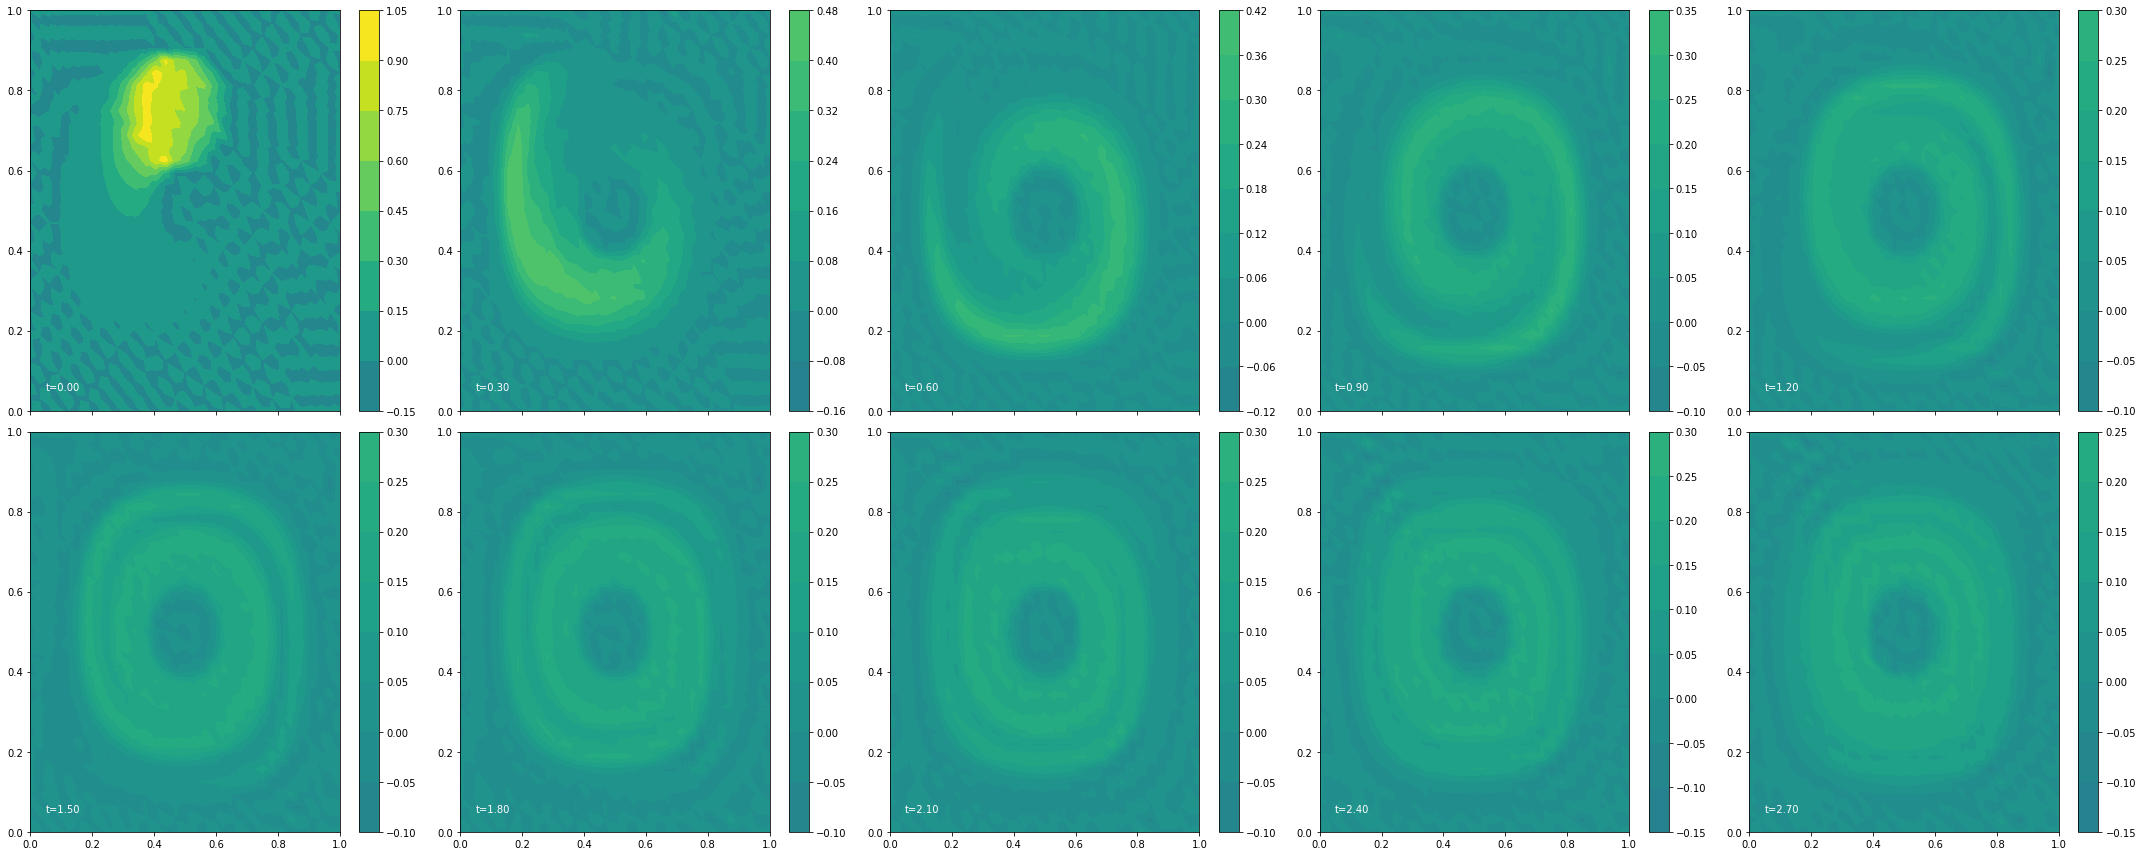

In [21]:
def plot_field(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (6 * cols, 6 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][0][idx], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

# print(len(solutions["u"]["forward"]))
# figsize = (5, 80)
steps = int(end_time / dt) / timesteps_per_export
print(steps)
rows, cols = 2, 5
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "forward", cmap='viridis',
    vmin=-1, vmax=1, rows=rows, cols=cols)

2 5


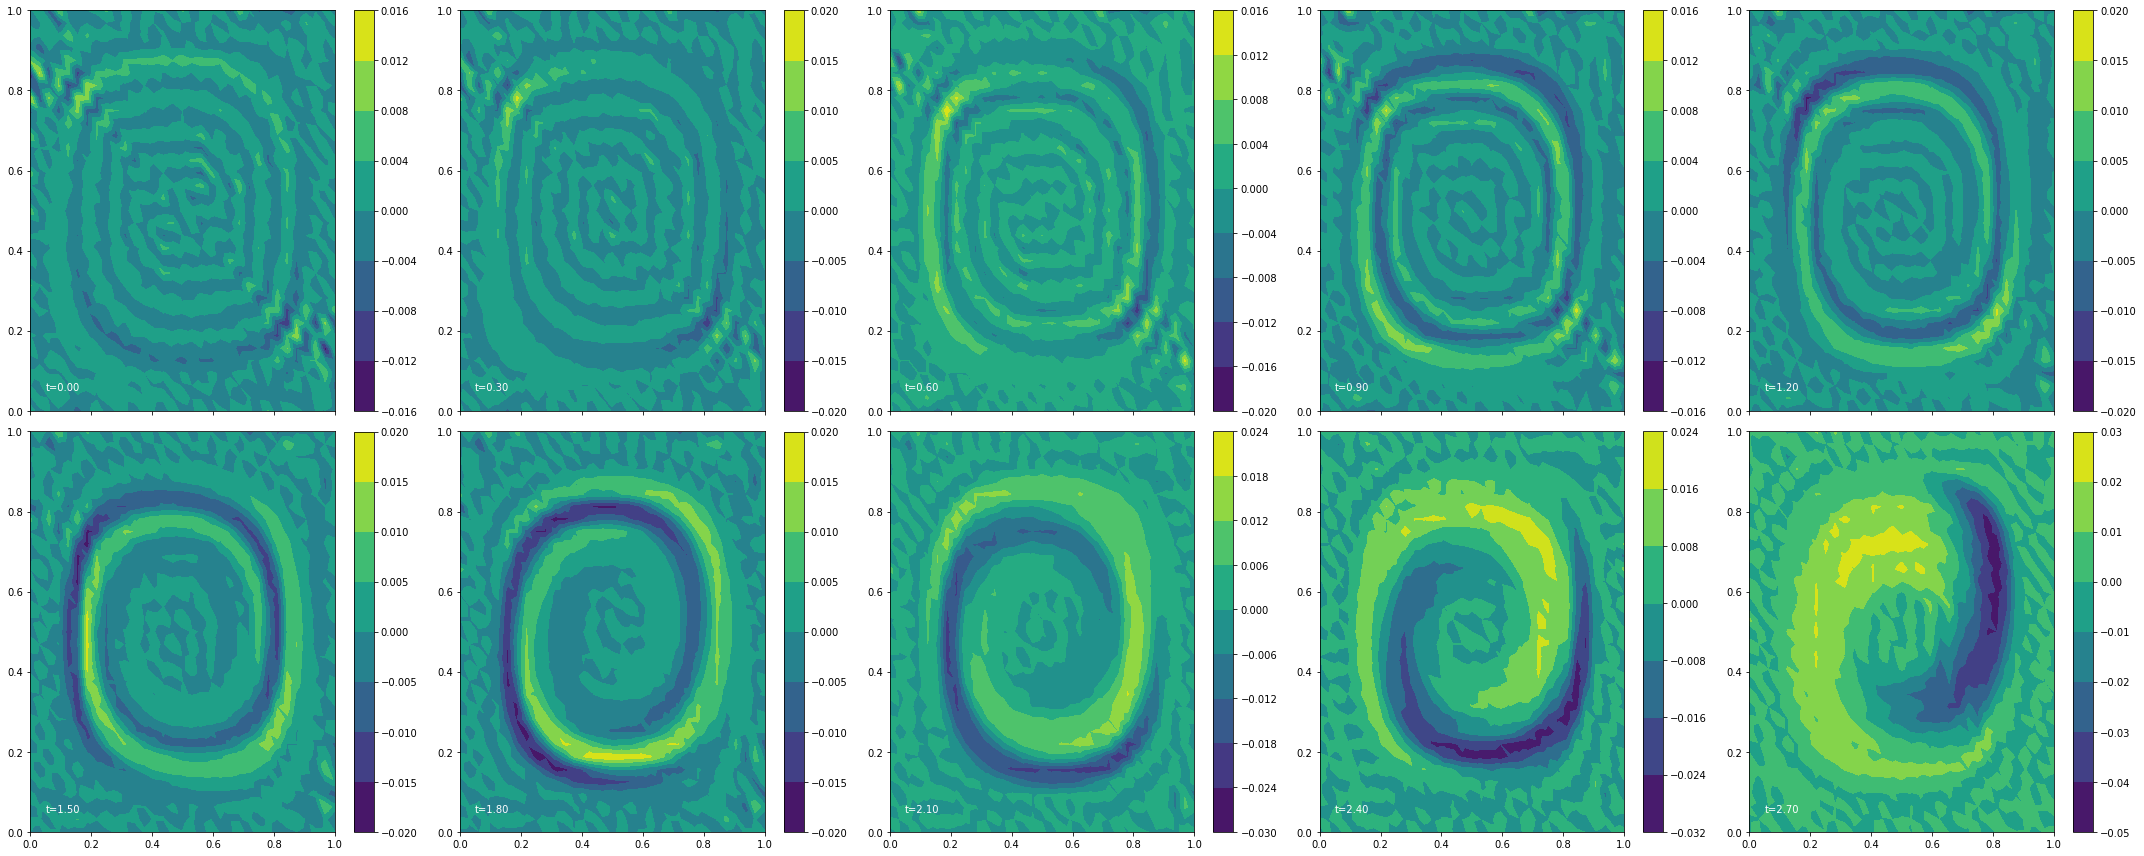

In [22]:
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "adjoint", cmap='viridis', rows=rows, cols=cols)

In [31]:
print(len(solutions['u']))
print(solutions['u'].keys())
print(len(solutions['u']['forward']))
print(len(solutions['u']['forward'][0]))

4
dict_keys(['forward', 'forward_old', 'adjoint', 'adjoint_next'])
1
10


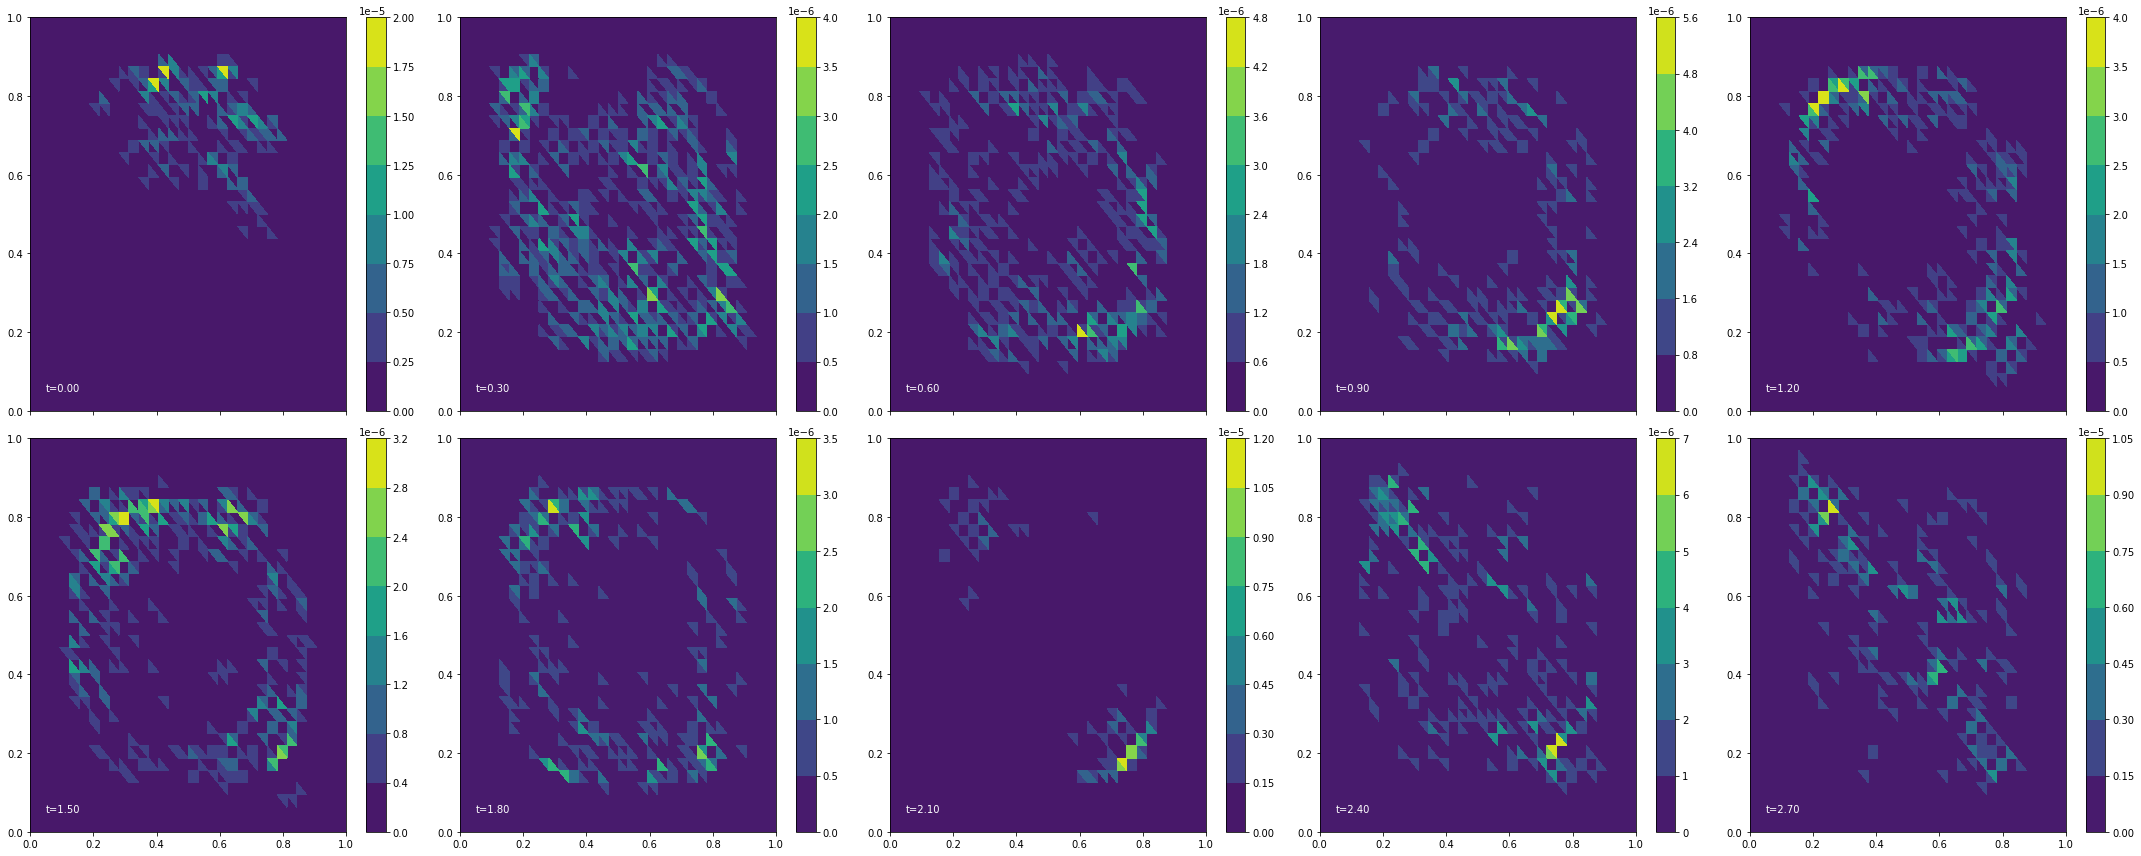

In [25]:
def plot_indicators(indicators, time_partition, **kwargs):
    P = time_partition
    rows = kwargs.pop('rows', (P.exports_per_subinterval[0] - 1) // 2)
    cols = kwargs.pop('cols', (P.num_subintervals * 2))
    steady = rows == cols == 1
#     print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (6 * cols, 6 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(indicators[0][idx], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

fig, axs, tcs = plot_indicators(indicators, time_partition, rows=rows, cols=cols)

## Is that actually correct? what the hell

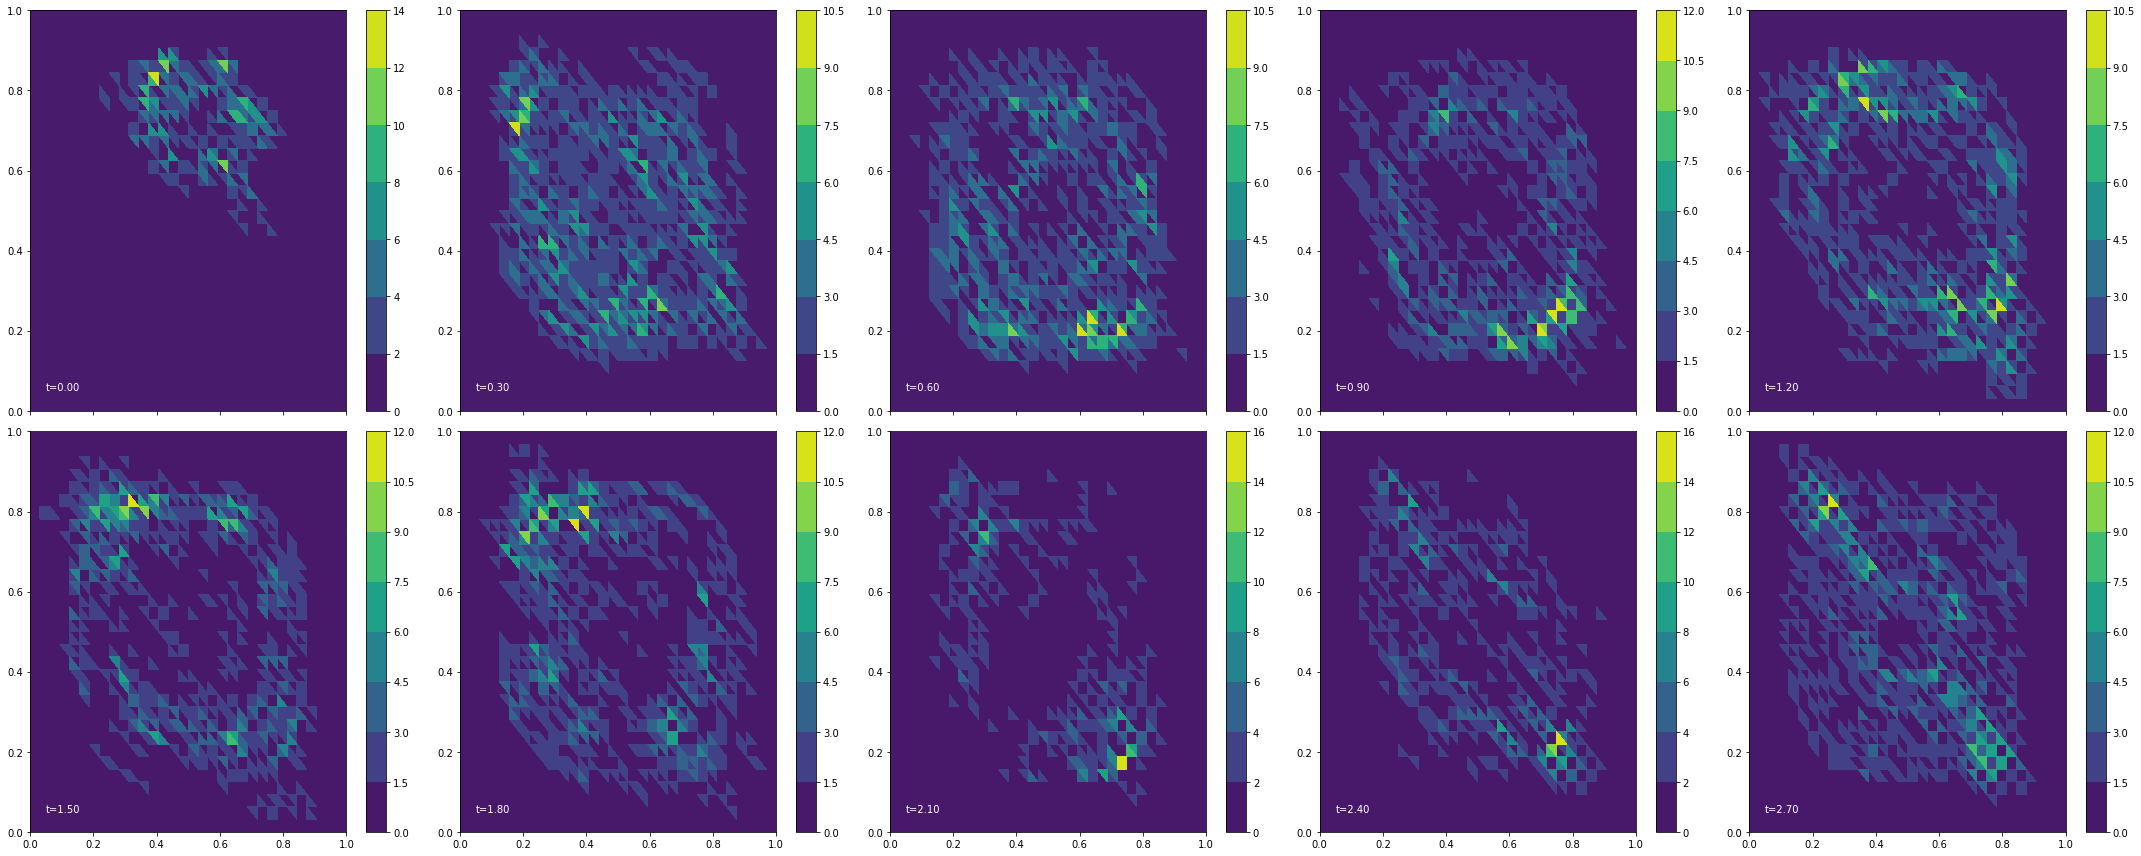

In [9]:
def standardize(arr):
    """
    Apply standardization based on mean and standard deviation
    """
    normed = (arr - np.mean(arr)) / np.std(arr)
    normed -= np.min(normed)
    normed += 1
    return normed

def lp_normalize(arr, p=2):
    """
    Normalize in L^p space.
    """
    retval = arr**p
    denom = sum(retval) ** (1 / p)
    retval /= denom
    return retval



p = 1
standardized_indicators = []
normalized_indicators = []
P0 = FunctionSpace(mesh_seq[0], "DG", 0)
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
        t2.append(Function(P0, val=lp_normalize(indicators[i][j].dat.data, p=p)))
    standardized_indicators.append(t1)
    normalized_indicators.append(t2)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols)

In [10]:
meshes = [UnitSquareMesh(n, n, diagonal='left') for i in range(len(indicators[0]))]
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor

for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=1e-3)
    mover.move();

Starting on mesh 0
   0   Min/Max 1.5479e-01   Residual 5.4567e-01   Equidistribution 9.9685e-01
   1   Min/Max 1.8390e-01   Residual 3.5045e-01   Equidistribution 9.9772e-01
   2   Min/Max 2.3768e-01   Residual 2.1670e-01   Equidistribution 9.9840e-01
   3   Min/Max 3.4199e-01   Residual 1.0249e-01   Equidistribution 9.9877e-01
   4   Min/Max 4.5860e-01   Residual 5.6599e-02   Equidistribution 9.9895e-01
   5   Min/Max 4.7424e-01   Residual 3.2449e-02   Equidistribution 9.9901e-01
   6   Min/Max 5.0718e-01   Residual 1.9011e-02   Equidistribution 9.9905e-01
Converged in 6 iterations.
Starting on mesh 1
   0   Min/Max 1.6788e-01   Residual 4.3839e-01   Equidistribution 9.9709e-01
   1   Min/Max 2.1697e-01   Residual 2.5264e-01   Equidistribution 9.9798e-01
   2   Min/Max 3.3495e-01   Residual 1.3235e-01   Equidistribution 9.9856e-01
   3   Min/Max 4.3151e-01   Residual 5.6227e-02   Equidistribution 9.9876e-01
   4   Min/Max 4.3313e-01   Residual 2.3759e-02   Equidistribution 9.9865e-01

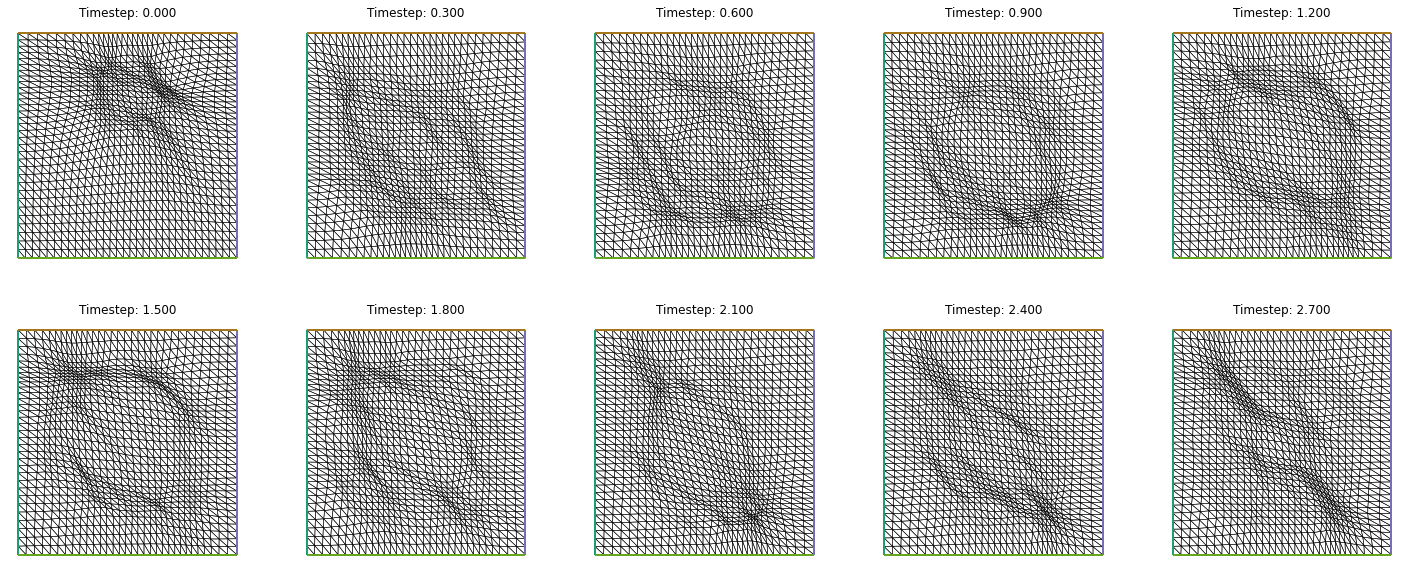

In [12]:
def plot_mesh(mesh, fig=None, axes=None, time_partition=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp


fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes) // rows), i % cols
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = i * dt * timesteps_per_export
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)
# fig.tight_layout(pad=0.5)
# plt.suptitle("Adapted meshes")

In [13]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

2 5


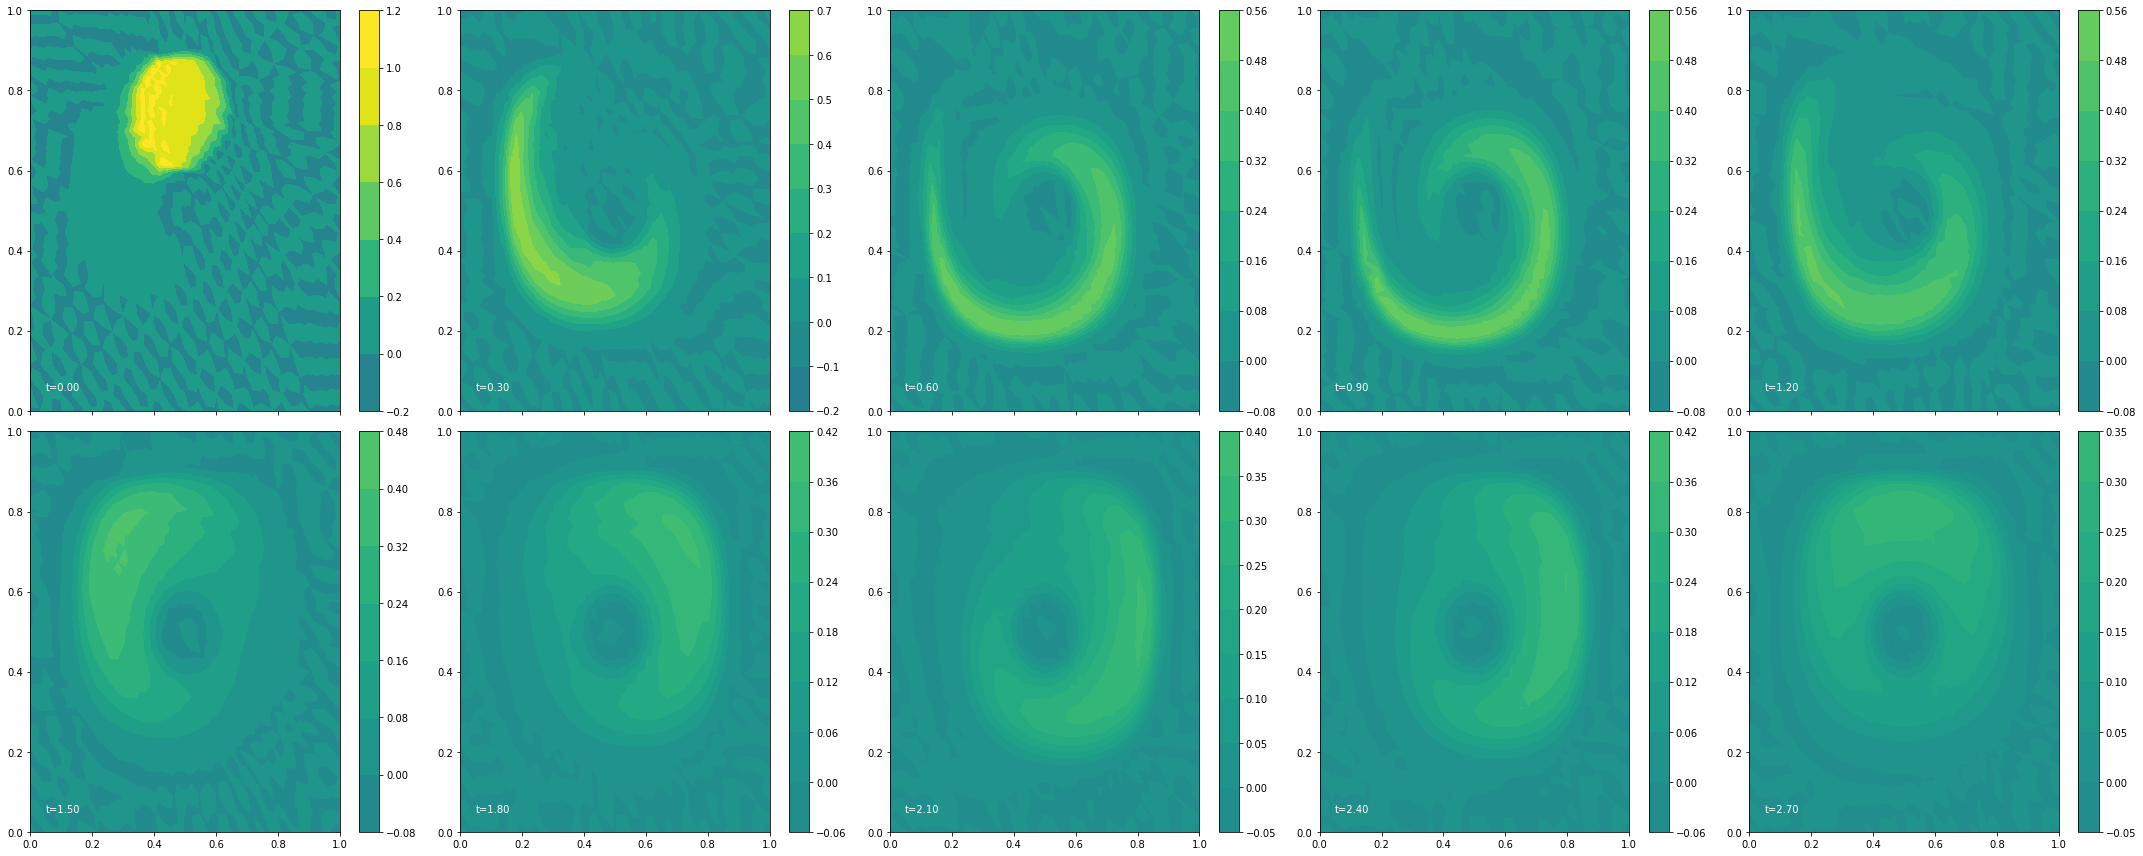

In [14]:
def plot_field2(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (6 * cols, 6 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][idx][0], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

# print(len(solutions))
# print(len(solutions['u']['forward']))
# print(len(solutions['u']['forward'][0]))

fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "forward", cmap='viridis',
    vmin=-1, vmax=1, rows=rows, cols=cols)


In [15]:
print("Error in forward solve: {:.5f}".format(mesh_seq.J))

Error in forward solve: 0.05737
